<a href="https://colab.research.google.com/github/cherylktt/tensorflow/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction. Now, it's time to learn about a new kind of transfer learning: fine-tuning.

In [ ]:
# Check if we're using a GPU
!nvidia-smi

Wed Apr 20 15:34:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions. Now, we could rewrite them all, however, this is tedious. So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks or elsewhere.

We've done this for some of the functions we've used previously here:
https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-04-20 15:34:39--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-04-20 15:34:39 (47.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py` so you'll have to redownload it if you want access to your helper functions.

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognising images of food).

Link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-04-20 15:34:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.136.128, 142.250.148.128, 74.125.129.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   119MB/s    in 1.4s    

2022-04-20 15:34:50 (119 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

> Dataset shapes:
* Number of total samples - 750 files
* Numbe of classes - 10 classes
* Batch size - default is 32
* Image size - (224, 224)
* Number of colour channels - 3 (red, green, blue)
* Number of classes in label tensors - 10

In [ ]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1): # take will unravel a batch
  print(images, labels)

tf.Tensor(
[[[[1.00000000e+01 7.00000000e+00 2.00000000e+00]
   [1.00000000e+01 7.00000000e+00 2.00000000e+00]
   [1.00000000e+01 7.00000000e+00 2.00000000e+00]
   ...
   [1.00000000e+00 1.00000000e+00 3.00000000e+00]
   [1.00000000e+00 1.00000000e+00 3.00000000e+00]
   [1.00000000e+00 1.00000000e+00 3.00000000e+00]]

  [[1.00000000e+01 7.00000000e+00 2.00000000e+00]
   [1.00000000e+01 7.00000000e+00 2.00000000e+00]
   [1.00000000e+01 7.00000000e+00 2.00000000e+00]
   ...
   [1.00000000e+00 1.00000000e+00 3.00000000e+00]
   [1.00000000e+00 1.00000000e+00 3.00000000e+00]
   [1.00000000e+00 1.00000000e+00 3.00000000e+00]]

  [[1.00000000e+01 7.00000000e+00 2.00000000e+00]
   [1.00000000e+01 7.00000000e+00 2.00000000e+00]
   [1.00000000e+01 7.00000000e+00 2.00000000e+00]
   ...
   [1.00000000e+00 1.00000000e+00 3.00000000e+00]
   [1.00000000e+00 1.00000000e+00 3.00000000e+00]
   [1.00000000e+00 1.00000000e+00 3.00000000e+00]]

  ...

  [[1.79785736e+02 1.70785736e+02 1.63785736e+02]
   [1

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straightforawrd, it runs our layers in sequential order. But the functional API gives us more flexibility with our models.

In [ ]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, you will need to normalise inputs (not necessary for EfficientNet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_feature_extraction")])

16719872/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220420-153501
Epoch 1/5
24/24 [==============================] - 29s 473ms/step - loss: 1.9245 - accuracy: 0.3933 - val_loss: 1.3681 - val_accuracy: 0.6990
Epoch 2/5
24/24 [==============================] - 9s 362ms/step - loss: 1.1628 - accuracy: 0.7227 - val_loss: 0.9360 - val_accuracy: 0.7961
Epoch 3/5
24/24 [==============================] - 7s 276ms/step - loss: 0.8505 - accuracy: 0.8147 - val_loss: 0.7483 - val_accuracy: 0.8454
Epoch 4/5
24/24 [==============================] - 7s 272ms/step - loss: 0.7007 - accuracy: 0.8347 - val_loss: 0.6576 - val_accuracy: 0.8503
Epoch 5/5
24/24 [==============================] - 7s 272ms/step - loss: 0.5989 - accuracy: 0.8600 - val_loss: 0.6000 - val_accuracy: 0.8470


In [ ]:
# Evaluate on full test dataset
results_10_percent = model_0.evaluate(test_data)
results_10_percent

79/79 [==============================] - 12s 140ms/step - loss: 0.6191 - accuracy: 0.8320


[0.6191487908363342, 0.8320000171661377]

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_2
1 rescaling_1
2 normalization_1
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [ ]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_1 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_1[0][0]']            
 )                              3)                                                   

In [ ]:
# How about a summary of our whole model?
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


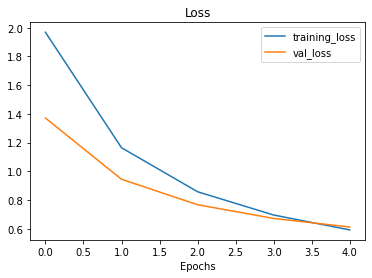

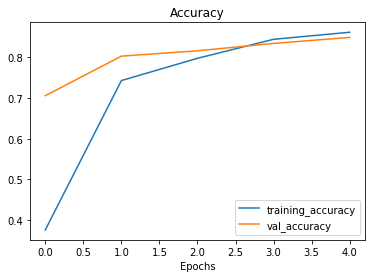

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer.

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280). But then when it passes through `GlobalAveragePooling2D`, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to `GlobalAveragePooling2D`.

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tesnors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global average pooled tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global average pooled tensor: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

**Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is a pretrained model outputs a **feature vector**, a long tensor of numbers which represents the **learned representation of the model on a particular sample**, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer, which can then be used to extract patterns out of the model for our own specific problem.

Let's try using `GlobalMaxPool2D`

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"2D global max pooled random tensor:\n {global_max_pooled_tensor}\n")

# Check the shape of the different tesnors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global max pooled tensor: {global_max_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global max pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global max pooled tensor: (1, 3)


In [ ]:
tf.reduce_max(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3` - use fine-tuning transfer learning with 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning with 100% of the training data with data augmentation

**Note:** Throughout all experiments, the same test dataset will be used to evaluate our model. This ensures consistency across evaluation metrics.

### Getting and preprocessing data for `model_1`

In [ ]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

--2022-04-20 16:33:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.182.128, 64.233.183.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.182.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   186MB/s    in 0.7s    

2022-04-20 16:33:12 (186 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

In [ ]:
# Inspect how many images we are working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'

In [ ]:
# Set up data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

* Preprocessing of images (augmenting them) happens on the GPU, which is much faster (ImageDataGenerator augments on the CPU)
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zoom, etc.
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2)
  #preprocessing.Rescale(1./255) # Keep for models like ResNet50V2, but EfficientNet's have rescaling built in
], name = "data_augmentation")

### Visualise our data augmentation layer (and see what happens to our data)

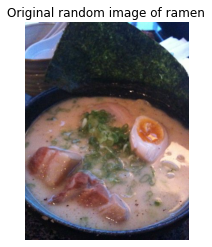

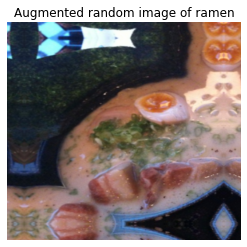

In [ ]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

# Pick a random class
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class

# Pick a random image
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read and plot in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image of {target_class}")
plt.axis(False);

# Read and plot the augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0), training=True)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image of {target_class}")
plt.axis(False);

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# Set up input shape and base_model, freezing the base model layers
input_shape = (224, 224, 3) # or IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentaiton) and don't train it
x = base_model(x, training=False)

# Pool output features of the base_model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the ouput
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220420-163329
Epoch 1/5
3/3 [==============================] - 15s 3s/step - loss: 2.5267 - accuracy: 0.1000 - val_loss: 2.2943 - val_accuracy: 0.1332
Epoch 2/5
3/3 [==============================] - 5s 2s/step - loss: 2.2392 - accuracy: 0.1857 - val_loss: 2.1681 - val_accuracy: 0.2138
Epoch 3/5
3/3 [==============================] - 7s 3s/step - loss: 2.0298 - accuracy: 0.4143 - val_loss: 2.0472 - val_accuracy: 0.2780
Epoch 4/5
3/3 [==============================] - 7s 3s/step - loss: 1.8818 - accuracy: 0.4286 - val_loss: 1.9621 - val_accuracy: 0.3306
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.7363 - accuracy: 0.5286 - val_loss: 1.8567 - val_accuracy: 0.4128


In [ ]:
# Check out a model summary
model_1.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
# Evaluate on the full test data set
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 11s 134ms/step - loss: 1.8737 - accuracy: 0.4072


[1.873666763305664, 0.40720000863075256]

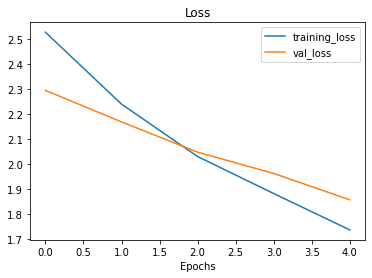

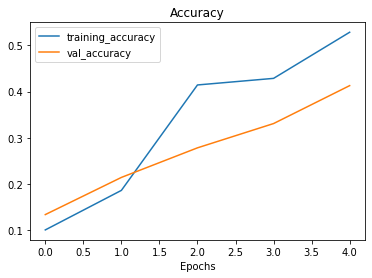

In [ ]:
# How do the loss curves look like for a model on 1% of the data with data augmentation?
plot_loss_curves(history_1)

## Model 2: Feature extraction transfer learning on 10% of the data with data augmentation

In [ ]:
# Get 10% of data
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data(10_food_classes_10_percent)

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create model_2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2)
  # preprocessing.Rescaling(1./255) # if you're using a model such as ResNet50V2, you'll need to rescale your data
], name="data_augmentation")

# Set up the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base_model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass the augmented images to base_model but keep the base_model in inference mode, this insures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D_l  (None, 1280)             0         
 ayer (GlobalAveragePooling2                                     
 D)                                                              
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                           

### Creating a ModelCheckpoint callback

The `ModelCheckpoint` callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [ ]:
# Set checkpoint path
checkpoint_path = "10_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

### Fit `model_2` passing in the ModelCheckpoint callback

In [ ]:
# Fit the model
initial_epochs = 5

history_2 = model_2.fit(train_data_10_percent,
                        epochs=initial_epochs,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_data_aug"),
                                   checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220420-163435
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0596 - accuracy: 0.3107
Epoch 1: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 28s 822ms/step - loss: 2.0596 - accuracy: 0.3107 - val_loss: 1.5365 - val_accuracy: 0.5970
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3958 - accuracy: 0.6480
Epoch 2: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 16s 635ms/step - loss: 1.3958 - accuracy: 0.6480 - val_loss: 1.0799 - val_accuracy: 0.7253
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0849 - accuracy: 0.7107
Epoch 3: saving model to 10_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 14s 574ms/step - loss: 1.0849 - accuracy: 0.7107 - val_loss: 0.8638 - val_accuracy: 0.7944
Epoc

In [ ]:
# Evaluate our model on all test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 11s 135ms/step - loss: 0.7180 - accuracy: 0.8040


[0.7179770469665527, 0.8040000200271606]

In [ ]:
results_10_percent, results_10_percent_data_aug

([0.6191487908363342, 0.8320000171661377],
 [0.7179770469665527, 0.8040000200271606])

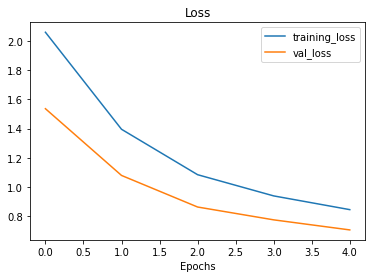

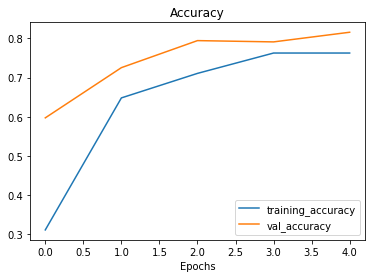

In [ ]:
# Plot training curves
plot_loss_curves(history_2)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a sepcific checkpoint.

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 12s 140ms/step - loss: 0.7070 - accuracy: 0.8080


In [ ]:
# If the results from our previously evaluated model_2 match the loaded weights, everything has worked.
results_10_percent_data_aug == loaded_weights_model_results

False

In [ ]:
results_10_percent_data_aug

[0.7070022225379944, 0.8080000281333923]

In [ ]:
loaded_weights_model_results

[0.7070024013519287, 0.8080000281333923]

In [ ]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# Check the difference between the 2 results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-1.78813934e-07  0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

> **Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data. Build a feature extractor model first, train the weights in the ouput layer, and then unfreeze some layers for fine-tuning.

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f1952971ad0> True
<keras.engine.sequential.Sequential object at 0x7f1952971cd0> True
<keras.engine.functional.Functional object at 0x7f1951a271d0> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f1951a909d0> True
<keras.layers.core.dense.Dense object at 0x7f1951c84550> True


In [ ]:
# What layers are in our base_model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_12 False
1 rescaling_11 False
2 normalization_11 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_re

In [ ]:
# How many trainable variables are in our base_model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True

# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning, you typically want to lower the learning rate by 10x
                metrics=["accuracy"])

**Note:** When using fine-tuning, it's best practice to lower your learning rate by some amount. A good rule of thumb is by at least 10x.

A good resource for information on this is the ULMFiT paper: https://arxiv.org/abs/1801.06146

In [ ]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_12 False
1 rescaling_11 False
2 normalization_11 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_re

In [ ]:
# How many trainable variables are there now?
print(len(model_2.trainable_variables))

12


In [ ]:
# Fine-tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_3 = model_2.fit(train_data_10_percent,
                        epochs=fine_tune_epochs,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        initial_epoch=history_2.epoch[-1], # start training from previous last epoch
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220420-122836
Epoch 5/10
24/24 [==============================] - 26s 621ms/step - loss: 0.7063 - accuracy: 0.7960 - val_loss: 0.5671 - val_accuracy: 0.8306
Epoch 6/10
24/24 [==============================] - 16s 637ms/step - loss: 0.5659 - accuracy: 0.8360 - val_loss: 0.5247 - val_accuracy: 0.8257
Epoch 7/10
24/24 [==============================] - 16s 636ms/step - loss: 0.5216 - accuracy: 0.8547 - val_loss: 0.5380 - val_accuracy: 0.8257
Epoch 8/10
24/24 [==============================] - 15s 619ms/step - loss: 0.4757 - accuracy: 0.8560 - val_loss: 0.5205 - val_accuracy: 0.8273
Epoch 9/10
24/24 [==============================] - 15s 628ms/step - loss: 0.4193 - accuracy: 0.8747 - val_loss: 0.4998 - val_accuracy: 0.8372
Epoch 10/10
24/24 [==============================] - 15s 609ms/step - loss: 0.3864 - accuracy: 0.8680 - val_loss: 0.4826 - val_accuracy: 0.8355


In [ ]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 11s 133ms/step - loss: 0.4917 - accuracy: 0.8380


In [ ]:
results_10_percent_data_aug

[0.7070022225379944, 0.8080000281333923]

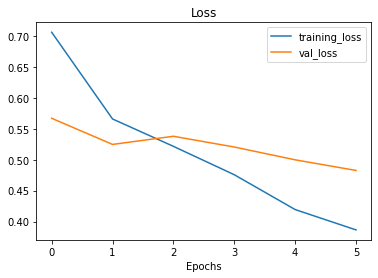

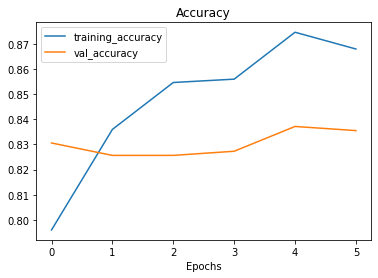

In [ ]:
# Plot the training curves of our fine-tuned model
plot_loss_curves(history_3)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning).

In [ ]:
# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compares 2 TensorFlow History objects.
  """

  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]
  
  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original_history metrics with new_history metrics
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Make plots for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine-tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Make plots for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine-tuning")
  plt.legend(loc="upper right")
  plt.title("Training and Validation Loss")

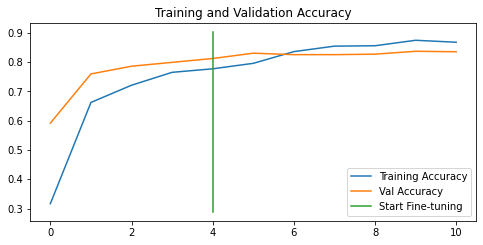

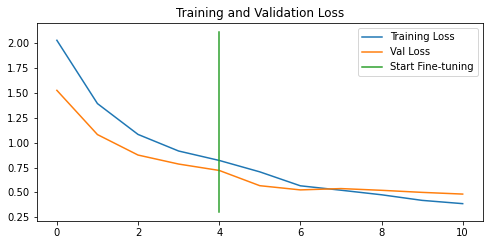

In [ ]:
compare_historys(history_2, history_3)

## Model 4: Fine-tuning and existing model on all of the data

In [ ]:
# Download and unzip 10 classes of Food101 data with all images (100% of the data)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-04-20 12:44:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.128, 172.217.212.128, 172.253.114.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   126MB/s    in 4.1s    

2022-04-20 12:44:33 (122 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Set up training and test dirs
train_dir_all_data = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [ ]:
# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 image_size=IMG_SIZE,
                                                                                 label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical")

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset).

Let's verify this.

In [ ]:
# Evaluate model 2 (this is the fine-tuned on 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 13s 148ms/step - loss: 0.4917 - accuracy: 0.8380


[0.49173805117607117, 0.8379999995231628]

In [ ]:
results_fine_tune_10_percent

[0.49173805117607117, 0.8379999995231628]

To train a fine-tuning model (`model_4`), we need to revert `model_2` back to its feature extraction weights. We can do that by loading weights from checkpoint.

In [ ]:
# Load checkpoints from checkpoint, so that we can fine-tune from 
# the same stage the 10 percent data model was fine-tuned from
model_2.load_weights(checkpoint_path)

In [ ]:
# Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 12s 140ms/step - loss: 0.7070 - accuracy: 0.8080


[0.7070022225379944, 0.8080000281333923]

In [ ]:
results_10_percent_data_aug

[0.7070022225379944, 0.8080000281333923]

The previous steps might seem confusing, but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation (`model_2`) and we saved the model's weights using `ModelCheckpoint` callback.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the `base_model` unfrozen (`model_3`).
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps as step 2 except this time, we're going to use all of that data (`model_4`).

In [ ]:
# Check which layers are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D_layer True
4 output_layer True


In [ ]:
# Check which layers are tunable in the base_model layer
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_12 False
1 rescaling_11 False
2 normalization_11 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_re

In [ ]:
# Recopmile model_2
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [ ]:
# Continue to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5

history_4 = model_2.fit(train_data_10_classes_full,
                        epochs=fine_tune_epochs,
                        steps_per_epoch=len(train_data_10_classes_full),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        initial_epoch=history_2.epoch[-1],
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="all_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/all_10_classes_fine_tune_last_10/20220420-130553
Epoch 5/10
235/235 [==============================] - 99s 371ms/step - loss: 0.7336 - accuracy: 0.7663 - val_loss: 0.4525 - val_accuracy: 0.8421
Epoch 6/10
235/235 [==============================] - 76s 320ms/step - loss: 0.5978 - accuracy: 0.8092 - val_loss: 0.4018 - val_accuracy: 0.8536
Epoch 7/10
235/235 [==============================] - 69s 291ms/step - loss: 0.5380 - accuracy: 0.8283 - val_loss: 0.3982 - val_accuracy: 0.8734
Epoch 8/10
235/235 [==============================] - 67s 284ms/step - loss: 0.4846 - accuracy: 0.8393 - val_loss: 0.4170 - val_accuracy: 0.8684
Epoch 9/10
235/235 [==============================] - 61s 258ms/step - loss: 0.4641 - accuracy: 0.8499 - val_loss: 0.3614 - val_accuracy: 0.8882
Epoch 10/10
235/235 [==============================] - 60s 252ms/step - loss: 0.4280 - accuracy: 0.8581 - val_loss: 0.3390 - val_accuracy: 0.8898


In [ ]:
# Let's evaluate on all of the test data
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 12s 138ms/step - loss: 0.3145 - accuracy: 0.8988


[0.314479261636734, 0.8988000154495239]

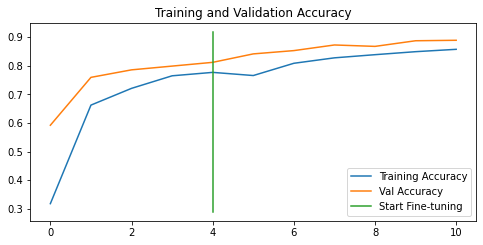

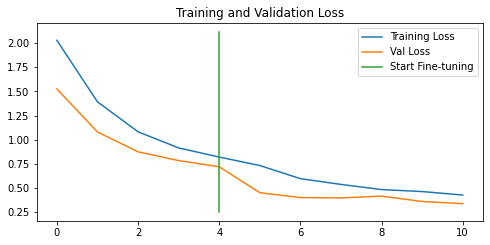

In [ ]:
# How did fine-tuning go with more data?
compare_historys(history_2, history_4)

## Viewing our experiment data on TensorBoard

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should be ~4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer Learning Experiments with 10 Food101 Classes" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning." \
  --one_shot

The TensorBoard experiments are available at: https://tensorboard.dev/experiment/mMExOyMiQl644f05QWQBNQ/#scalars

# Exercises

## Exercise 1
Recreate one of the experiments with the `EfficientNetB4` architecture instead.

In [ ]:
# Import helper_function.py
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data

# Download the data and preprocess it
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

# Create train and test directories
train_dir_10_percent_B4 = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# Set up data loaders
train_data_10_percent_B4 = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent_B4,
                                                                               image_size=(224, 224),
                                                                               label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=(224, 224),
                                                                label_mode="categorical")

# Recreate model_0 using EfficientNetB4 instead
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_2D_layer")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

model_5 = tf.keras.Model(inputs, outputs)

# Compile the model
model_5.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model to 10% of training data
history_5 = model_5.fit(train_data_10_percent_B4,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_percent_B4),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                              experiment_name="10_percent_feature_extraction_efficientnetB4")])

--2022-04-20 18:41:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-04-20 18:41:07 (51.3 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]

--2022-04-20 18:41:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.126.128, 173.194.193.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Le

In [ ]:
# Evaluate model_5 on test data
results_10_percent_B4 = model_5.evaluate(test_data)

79/79 [==============================] - 29s 354ms/step - loss: 0.5567 - accuracy: 0.8392


In [ ]:
# Compare model_5 evaluation to that of model_0
results_10_percent, results_10_percent_B4

([0.6125487089157104, 0.8420000076293945],
 [0.5566954016685486, 0.8392000198364258])

> EfficientNetB0 performed 1% better than EfficientNetB4 on 10% of 10 classes of Food101 data. Perhaps it will do better on 100% of 10 classes of Food101 data.

## Exercise 2

Use feature extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using `tf.keras.applications.EfficientNetB0` as the base model. Use the `ModelCheckpoint` callback to save the weights to file.

In [ ]:
# Import helper_function.py
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data

# Download the data and preprocess it
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
unzip_data("10_food_classes_10_percent.zip")

# Create train and test directories
train_dir_10_percent_10_epochs = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# Set up data loaders
train_data_10_percent_10_epochs = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent_10_epochs,
                                                                               image_size=(224, 224),
                                                                               label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=(224, 224),
                                                                label_mode="categorical")

--2022-04-20 14:08:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-04-20 14:08:45 (36.6 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]

--2022-04-20 14:08:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 173.194.195.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

input_shape = (224, 224, 3)
initial_epochs = 10

# Create the model using EfficientNetB0
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

model_6 = keras.Model(inputs, outputs)

# Compile the model
model_6.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Create ModelCheckpoint callback
checkpoint_path_10_epochs = "10_percent_10_epochs_model_checkpoints_weights/checkpoint.ckpt"
checkpoint_callback_10_epochs = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path_10_epochs,
                                                                   save_weights_only=True,
                                                                   save_best_only=False,
                                                                   verbose=1)

# Fit the model
history_6 = model_6.fit(train_data_10_percent_10_epochs,
                        epochs=initial_epochs,
                        steps_per_epoch=len(train_data_10_percent_10_epochs),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_10_epochs"),
                                   checkpoint_callback_10_epochs])

Saving TensorBoard log files to: transfer_learning/10_percent_10_epochs/20220420-141844
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.9259 - accuracy: 0.3907
Epoch 1: saving model to 10_percent_10_epochs_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 18s 446ms/step - loss: 1.9259 - accuracy: 0.3907 - val_loss: 1.3653 - val_accuracy: 0.6793
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.1590 - accuracy: 0.7400
Epoch 2: saving model to 10_percent_10_epochs_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 9s 374ms/step - loss: 1.1590 - accuracy: 0.7400 - val_loss: 0.9166 - val_accuracy: 0.8026
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.8468 - accuracy: 0.8053
Epoch 3: saving model to 10_percent_10_epochs_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 7s 286ms/step - loss: 0.8468 - accuracy: 0.8053 - val_loss: 0.

In [ ]:
# Evaluate model_6 on all test data
results_10_percent_10_epochs = model_6.evaluate(test_data)

79/79 [==============================] - 12s 142ms/step - loss: 0.5028 - accuracy: 0.8472


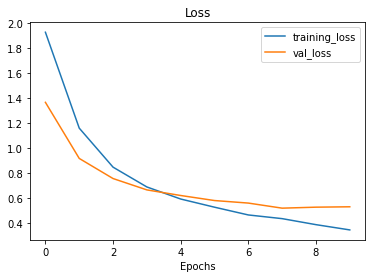

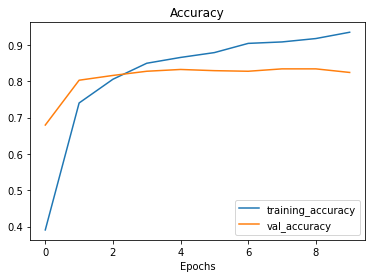

In [ ]:
# Plot training curves
plot_loss_curves(history_6)

## Exercise 3 

Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs.

In [ ]:
# Load in saved model weights
model_6.load_weights(checkpoint_path_10_epochs)

In [ ]:
# Set the last 20 layers of base_model to trainable
base_model.trainable=True

for layer in base_model.layers[:-20]:
  layer.trainable=False

# Recompile the model
model_6.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [ ]:
# Check layers in model_6
model_6.layers

In [ ]:
# Check which layers are trainable
for i, layer in enumerate(model_6.layers[1].layers):
  print(i, layer.name, layer.trainable)

0 input_16 False
1 rescaling_15 False
2 normalization_15 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_re

In [ ]:
# Fine-tune for another 10 epochs
fine_tune_epochs = initial_epochs + 10

# Refit the model
history_7 = model_6.fit(train_data_10_percent_10_epochs,
                        epochs=fine_tune_epochs,
                        steps_per_epoch=len(train_data_10_percent_10_epochs),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        initial_epoch=history_6.epoch[-1],
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_fine_tune_last_20")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_20/20220420-145256
Epoch 10/20
24/24 [==============================] - 10s 391ms/step - loss: 0.0177 - accuracy: 0.9987 - val_loss: 0.4325 - val_accuracy: 0.8618
Epoch 11/20
24/24 [==============================] - 10s 399ms/step - loss: 0.0148 - accuracy: 0.9987 - val_loss: 0.5159 - val_accuracy: 0.8339
Epoch 12/20
24/24 [==============================] - 10s 384ms/step - loss: 0.0161 - accuracy: 0.9973 - val_loss: 0.4394 - val_accuracy: 0.8553
Epoch 13/20
24/24 [==============================] - 10s 394ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.3856 - val_accuracy: 0.8684
Epoch 14/20
24/24 [==============================] - 10s 397ms/step - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.4081 - val_accuracy: 0.8553
Epoch 15/20
24/24 [==============================] - 8s 294ms/step - loss: 0.0097 - accuracy: 0.9987 - val_loss: 0.4358 - val_accuracy: 0.8602
Epoch 16/20
24/24 [======================

In [ ]:
# Evaluate the fine-tuned model
results_fine_tuned_last_20 = model_6.evaluate(test_data)

79/79 [==============================] - 11s 133ms/step - loss: 0.4174 - accuracy: 0.8680


In [ ]:
results_10_percent_10_epochs

[0.5028142929077148, 0.8471999764442444]

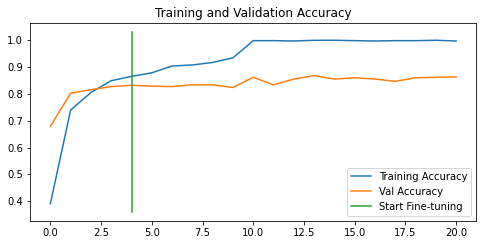

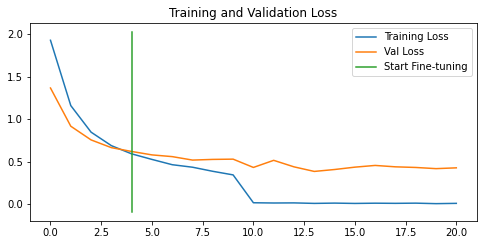

In [ ]:
# Compare history
compare_historys(history_6, history_7)

## Exercise 4 

Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs.

In [ ]:
# Load in saved model weights
model_6.load_weights(checkpoint_path_10_epochs)

In [ ]:
# Fine-tune the last 30 layers
base_model.trainable=True

for layer in base_model.layers[:-30]:
  layer.trainable=False

# Recompile the model
model_6.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [ ]:
# Check which layers are trainable
for i, layer in enumerate(model_6.layers[1].layers):
  print(i, layer.name, layer.trainable)

0 input_16 False
1 rescaling_15 False
2 normalization_15 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_re

In [ ]:
# Refit the model
fine_tune_epochs = initial_epochs + 10

history_8 = model_6.fit(train_data_10_percent_10_epochs,
                        epochs=fine_tune_epochs,
                        steps_per_epoch=len(train_data_10_percent_10_epochs),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        initial_epoch=history_6.epoch[-1],
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_fine_tune_last_30")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_30/20220420-145505
Epoch 10/20
24/24 [==============================] - 21s 453ms/step - loss: 0.8393 - accuracy: 0.8107 - val_loss: 0.4697 - val_accuracy: 0.8372
Epoch 11/20
24/24 [==============================] - 7s 292ms/step - loss: 0.5137 - accuracy: 0.9160 - val_loss: 0.4996 - val_accuracy: 0.8240
Epoch 12/20
24/24 [==============================] - 7s 290ms/step - loss: 0.3789 - accuracy: 0.9387 - val_loss: 0.4728 - val_accuracy: 0.8273
Epoch 13/20
24/24 [==============================] - 9s 379ms/step - loss: 0.3168 - accuracy: 0.9587 - val_loss: 0.4606 - val_accuracy: 0.8438
Epoch 14/20
24/24 [==============================] - 7s 290ms/step - loss: 0.2439 - accuracy: 0.9600 - val_loss: 0.4520 - val_accuracy: 0.8372
Epoch 15/20
24/24 [==============================] - 9s 380ms/step - loss: 0.1881 - accuracy: 0.9800 - val_loss: 0.4643 - val_accuracy: 0.8322
Epoch 16/20
24/24 [==========================

In [ ]:
# Evaluate the model on full test data
results_fine_tuned_last_30 = model_6.evaluate(test_data)

79/79 [==============================] - 11s 132ms/step - loss: 0.4181 - accuracy: 0.8624


In [ ]:
results_fine_tuned_last_20

[0.417405366897583, 0.8679999709129333]

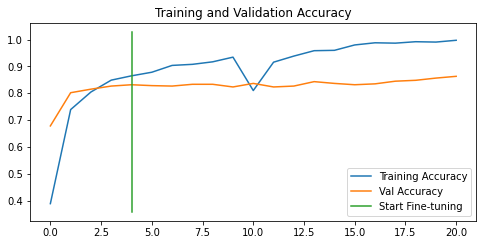

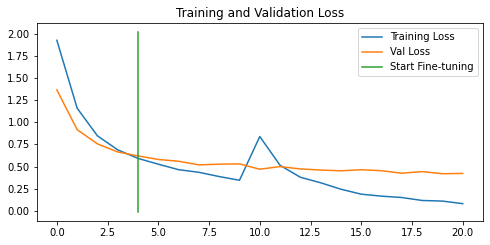

In [ ]:
# Compare history
compare_historys(history_6, history_8)

Unfreezing the last 20 or last 30 layers did not have much impact on the model.

In [ ]:
# Upload all models to TensorBoard
!tensorboard dev upload --logdir ./transfer_learning \
  --name "All Transfer Learning Experiments with 10 Food101 Classes" \
  --description "Includes models built for exercises." \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/OrsjZcoqTkWGCAWXE4Q2Ig/

[2022-04-20T15:02:30] Started scanning logdir.
[2022-04-20T15:02:38] Total uploaded: 384 scalars, 0 tensors, 9 binary objects (8.1 MB)
[2022-04-20T15:02:38] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/OrsjZcoqTkWGCAWXE4Q2Ig/


The TensorBoard for all models in this notebook can be found here: https://tensorboard.dev/experiment/OrsjZcoqTkWGCAWXE4Q2Ig/

Best performing models:
1. `model_4` (100% fine-tune last 10 layers): 88.9%
2. `model_7` (10% fine-tune last 20 layers): 86.35%
3. `model_0` (10% feature extraction): 84.7%

## Exercise 5

Write a function to visualise an image from any dataset (train or test file) and any class, visualise it, and make a prediction on it using a trained model.

> Use `model_0` to make a prediction.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

def view_random_image(target_dir, target_class):
  """
  View a random image from target_dir of target_class
  """

  # Set up the target directory
  target_folder = target_dir + "/" + target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  img = img/255.
  plt.imshow(img)
  plt.title(f"Random image of {target_class}")
  plt.axis(False)

  return img

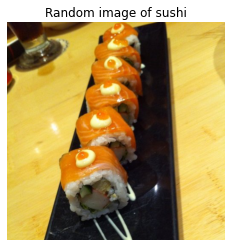

In [ ]:
# View a random image of pizza from the 10% training dataset
img = view_random_image("10_food_classes_10_percent/train", "sushi")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import tensorflow as tf
import numpy as np

def make_prediction(model, test_data=test_data, classes=test_data.class_names):
  """
  Picks a random image from test data set, make a prediction based on model, plots it and labels it with a prediction and truth label.
  """

  # Choose the image
  i = random.randint(0, 33)
  image, label = test_data.as_numpy_iterator().next()

  # Create predictions and targets
  pred_probs = model.predict(tf.expand_dims(image[i], axis=0))
  pred_label = classes[np.argmax(pred_probs)]
  true_label = classes[np.argmax(label[i])]

  image = image/255.

  # Plot the image
  plt.imshow(image[i])
  plt.axis(False)

  # CHange the colour of the titles depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  
  # Add xlabel information (prediction/true label)
  plt.title("Prediction: {} \n Probability: {:2.0f}% \n Actual: {}".format(pred_label,
                                                100*tf.reduce_max(pred_probs),
                                                true_label),
            color=color, fontsize=13)

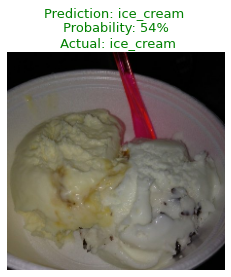

In [ ]:
make_prediction(model_0)

Create a model and train it on 100% of data for 40 epochs.

In [ ]:
# Download and unzip 10 classes of Food101 data with all images (100% of the data)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2022-04-20 17:08:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.198.128, 64.233.191.128, 173.194.74.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.198.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  96.3MB/s    in 5.8s    

2022-04-20 17:08:45 (85.7 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Set up training and test dirs
train_dir_all_data = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 image_size=IMG_SIZE,
                                                                                 label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical")

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
# Create the model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history = model.fit(train_data_10_classes_full,
                        epochs=40,
                        steps_per_epoch=len(train_data_10_classes_full),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)))

Epoch 1/40
235/235 [==============================] - 46s 162ms/step - loss: 0.8829 - accuracy: 0.7524 - val_loss: 0.4309 - val_accuracy: 0.8668
Epoch 2/40
235/235 [==============================] - 35s 148ms/step - loss: 0.5196 - accuracy: 0.8437 - val_loss: 0.3586 - val_accuracy: 0.8865
Epoch 3/40
235/235 [==============================] - 36s 151ms/step - loss: 0.4458 - accuracy: 0.8637 - val_loss: 0.3308 - val_accuracy: 0.8914
Epoch 4/40
235/235 [==============================] - 36s 153ms/step - loss: 0.3973 - accuracy: 0.8803 - val_loss: 0.3173 - val_accuracy: 0.8865
Epoch 5/40
235/235 [==============================] - 35s 149ms/step - loss: 0.3614 - accuracy: 0.8912 - val_loss: 0.3043 - val_accuracy: 0.9030
Epoch 6/40
235/235 [==============================] - 35s 149ms/step - loss: 0.3390 - accuracy: 0.8979 - val_loss: 0.2912 - val_accuracy: 0.9030
Epoch 7/40
235/235 [==============================] - 36s 149ms/step - loss: 0.3156 - accuracy: 0.9057 - val_loss: 0.2694 - val_ac

In [ ]:
model.evaluate(test_data)

79/79 [==============================] - 13s 146ms/step - loss: 0.3143 - accuracy: 0.9020


[0.314266562461853, 0.9020000100135803]

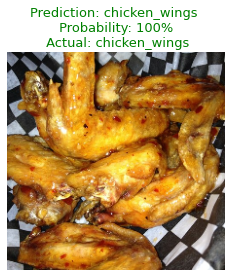

In [ ]:
# Use the new model to make predictions
make_prediction(model)